In [16]:
!pip install mplsoccer statsbombpy
from mplsoccer import Pitch, VerticalPitch, add_image, FontManager, Sbopen
import statsbombpy
from statsbombpy import sb
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap


In [30]:
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/'
                       'rubikmonoone/RubikMonoOne-Regular.ttf')
path_eff = [path_effects.Stroke(linewidth=1, foreground='white'),
            path_effects.Normal()]
bins = (1, 1, 6)

In [42]:
parser = Sbopen()
df_lineup = parser.lineup(3943043)
df, _, _, df_tactics = parser.event(3943043)

# get starting XI and formation
mask_start = (df.type_name == 'Starting XI') & (df.team_name == 'Spain')
formation = df.loc[mask_start, 'tactics_formation'].iloc[0]
start_id = df.loc[mask_start, 'id']
df_start = df_tactics[df_tactics['id'].isin(start_id)].copy()

# filter open-play passes
df_pass = df[(df.type_name == 'Pass') & (df.team_name == 'Spain') &
             (~df.sub_type_name.isin(['Free Kick', 'Throw-in',
                                      'Goal Kick', 'Kick Off', 'Corner']))].copy()
mask_success = df_pass['outcome_name'].isnull()


In [43]:
# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#15242e', '#4393c4'], N=10)

# fontmanager for google font (robotto)
robotto_regular = FontManager()

path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

In [46]:
player_short_names = {
    'Álvaro Borja Morata Martín': 'Álvaro Morata',
    'Aymeric Laporte': 'Aymeric Laporte',
    'Daniel Carvajal Ramos': 'Dani Carvajal',
    'Fabián Ruiz Peña': 'Fabián Ruiz',
    'Rodrigo Hernández Cascante': 'Rodri',
    'Unai Simón Mendibil': 'Unai Simón',
    'Daniel Olmo Carvajal': 'Dani Olmo',
    'Marc Cucurella Saseta': 'Marc Cucurella',
    'Robin Aime Robert Le Normand': 'Robin Le Normand',
    'Nicholas Williams Arthuer': 'Nico Williams',
    'Lamine Yamal Nasraoui Ebana': 'Lamine Yamal'
}

df_start['player_name'] = df_start['player_name'].map(player_short_names).str.replace(' ', '\n')

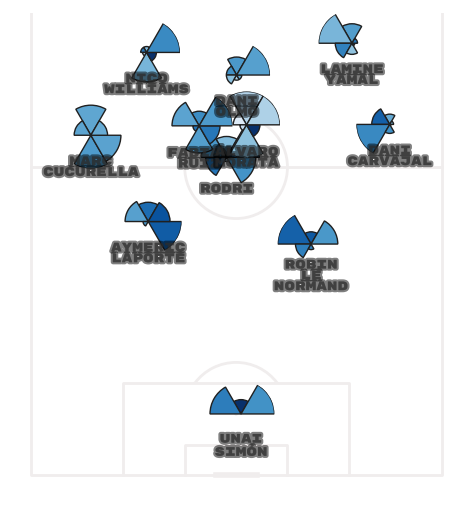

In [49]:
pitch = VerticalPitch(line_color='#f0eded', pad_top=-30)
# pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='grass', line_color='white',pad_top=-30)
angle, distance = pitch.calculate_angle_and_distance(df_pass.x, df_pass.y, df_pass.end_x,
                                                     df_pass.end_y)

fig, ax = pitch.draw(figsize=(4.8215, 7))
for i, row in df_start.iterrows():
    mask = df_pass.player_id == row.player_id
    df_player = df_pass[mask]
    avg_x, avg_y = df_player.x.mean(), df_player.y.mean()
    ax_player = pitch.inset_axes(avg_x, avg_y, height=13, polar=True, zorder=2, ax=ax)
    bs_count_all = pitch.bin_statistic_sonar(df_pass[mask].x, df_pass[mask].y, angle[mask],
                                             bins=bins, center=True)
    bs_distance = pitch.bin_statistic_sonar(df_pass[mask].x, df_pass[mask].y, angle[mask],
                                            values=distance[mask], statistic='mean',
                                            bins=bins, center=True)
    pitch.sonar(bs_count_all, stats_color=bs_distance, vmin=0, vmax=30,
                cmap='Blues', ec='#202020', zorder=3, ax=ax_player)
    # adjust the text  little to avoid overlaps
    if row.player_name == 'Andrés\nIniesta':
        avg_y = avg_y - 6
    elif row.player_name == "Samuel\nEto'o":
        avg_y = avg_y + 4
    pitch.text(avg_x - 6, avg_y, row.player_name, va='center', ha='center', path_effects=path_eff,
               fontproperties=fm_rubik.prop, fontsize=9, color='#353535', zorder=5, ax=ax,alpha=0.5)


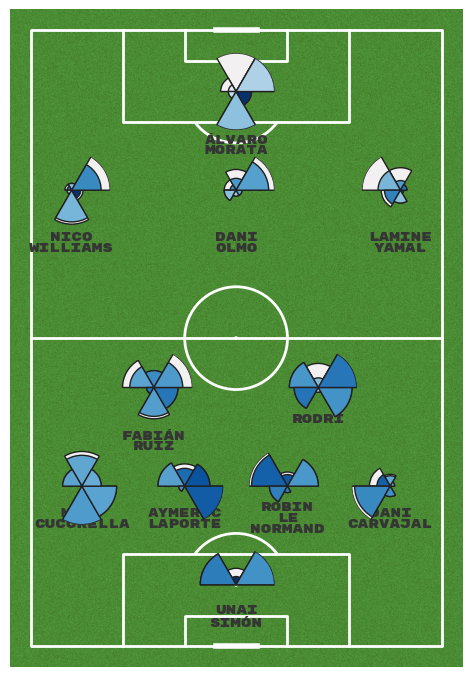

In [39]:
# pitch = VerticalPitch(line_color='#f0eded')
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = pitch.draw(figsize=(4.8215, 7))
axs = pitch.formation(formation, positions=df_start.position_id, height=15, polar=True, kind='axes',
                      ax=ax)
player_text = pitch.formation(formation, positions=df_start.position_id,
                              xoffset=[-6, -6, -6, -6, -6, -6, -10, -10, -10, -10, -10],
                              text=df_start.player_name.tolist(), va='center', ha='center',
                              fontproperties=fm_rubik.prop,
                              fontsize=9, color='#353535', kind='text', ax=ax)

for key in axs.keys():
    player_id = df_start.loc[df_start.position_id == key, 'player_id'].iloc[0]
    mask = df_pass.player_id == player_id
    bs_count_all = pitch.bin_statistic_sonar(df_pass[mask].x, df_pass[mask].y, angle[mask],
                                             bins=bins, center=True)
    bs_count_success = pitch.bin_statistic_sonar(df_pass[mask & mask_success].x,
                                                 df_pass[mask & mask_success].y,
                                                 angle[mask & mask_success],
                                                 bins=bins, center=True)
    bs_distance = pitch.bin_statistic_sonar(df_pass[mask].x, df_pass[mask].y, angle[mask],
                                            values=distance[mask], statistic='mean',
                                            bins=bins, center=True)
    pitch.sonar(bs_count_success, stats_color=bs_distance, vmin=0, vmax=30,
                cmap='Blues', ec='#202020', zorder=3, ax=axs[key])
    pitch.sonar(bs_count_all, color='#f2f0f0', zorder=2, ec='#202020', ax=axs[key])

plt.show()  # If you are using a Jupyter notebook you do not need this line